In [1]:
import numpy as np
from scipy.special import erf
from scipy.stats import beta as beta_dist
from scipy.stats import truncnorm
from scipy.interpolate import interp1d
import scipy.stats as stats
import pandas as pd
from scipy import interpolate
from scipy import integrate
import random
import argparse
import os
import glob
import warnings
warnings.filterwarnings("ignore")

#uniform model
def hyper_prior_U(dataset,mlo,mup):
    return (( dataset >= mlo) & (dataset <= mup))/np.abs(mup-mlo)


#logu
def hyper_prior_logu(dataset,mlo,mup):
    return (( dataset >= mlo) & (dataset <= mup))/( dataset * np.log(mup / mlo) )

#turn_on_pow
def hyper_prior_turn_on_pow(dataset, alpha, mmin, mmax, delta_m):
    parameters = dict(
        alpha=alpha, mmin=mmin, mmax=mmax, delta_m=delta_m)
    pow_norm = norm_ppow(parameters)
    probability = turn_on_pow(dataset, parameters, pow_norm)
    return probability

def turn_on_pow(ms, parameters, pow_norm):
    al, mn, mx, delta_m = extract_mass_parameters(parameters)
    p_pow = ppow(ms, parameters) / pow_norm
    return  p_pow 

def ppow(ms, parameters):
    """1d unnormalised powerlaw mass probability with smoothed low-mass end"""
    al, mn, mx, delta_m = extract_mass_parameters(parameters)
    return ms**(-al) * window(ms, mn, mx, delta_m)

def norm_ppow(parameters):
    """normalise ppow, requires m1s, an array of m values, and dm, the spacing of
    that array"""
    return np.trapz(ppow(m1s, parameters), m1s)

def window(ms, mn, mx, delta_m):
    """Apply a one sided window between mmin and mmin+dm to the mass pdf.

    The upper cut off is a step function,
    the lower cutoff is a logistic rise over delta_m solar masses.

    See T&T18 Eq

    """
    dM = mx - mn
    delta_m /= dM
    # some versions of numpy can't deal with pandas columns indexing an array
    ms_arr = np.array(ms)
    sel_p = (ms_arr >= mn) & (ms_arr <= (mn + delta_m * dM))
    ms_p = ms_arr[sel_p] - mn
    Zp = np.nan_to_num(2 * delta_m * (1 / (2 * ms_p / dM) +
                       1 / (2 * ms_p / dM - 2 * delta_m)))
    window = np.ones_like(ms)
    window[(ms_arr < mn) | (ms_arr > mx)] = 0
    window[sel_p] = 1 / (np.exp(Zp) + 1)
    return window

def extract_mass_parameters(parameters):
    """extract the parameters of the mass distribution hyperparameters used in
    T&T18 from either a list or dictionary."""
    if isinstance(parameters, list):
        return parameters
    elif isinstance(parameters, dict):
        keys = ['alpha', 'mmin', 'mmax', 'delta_m']
        return [parameters[key] for key in keys]

# set up arrays for numerical normalisation
# this doesn't include VT(m)
m1s = np.linspace(0.9, 2.9, 200)
dm = m1s[1] - m1s[0]


#pow
def hyper_prior_pow(dataset,mlo,mup,beta):
    beta=-1*beta
    return (( dataset >= mlo) & (dataset <= mup))*((1+beta)/(mup**(1+beta)-mlo**(1+beta)))*dataset**beta

#lognorm
def hyper_prior_lognorm(dataset, s_mu, s_sigma):
    return np.exp(- (np.log(dataset) - s_mu)**2 / (2 * s_sigma**2)) /\
        (2 * np.pi * s_sigma**2)**0.5/(dataset)

#G
def hyper_prior_G(dataset, s_mu, s_sigma):
    return np.exp(- (dataset - s_mu)**2 / (2 * s_sigma**2)) /\
        (2 * np.pi * s_sigma**2)**0.5


#3G
def hyper_prior_3G(dataset, mu1, sigma1,mu2,sigma2,alpha,mu3,sigma3,beta):
    if mu1 < mu2 and mu3>mu2  and alpha+beta<=1:
        return alpha*(np.exp(- (dataset - mu1)**2 / (2 * sigma1**2)) /(2 * np.pi * sigma1**2)**0.5)\
        +beta*(np.exp(- (dataset - mu2)**2 / (2 * sigma2**2)) /(2 * np.pi * sigma2**2)**0.5)\
        +(1-alpha-beta)*(np.exp(- (dataset - mu3)**2 / (2 * sigma3**2)) /(2 * np.pi * sigma3**2)**0.5)
    else:
        return 0

#2G 
def hyper_prior_2G(dataset, mu1, sigma1,mu2,sigma2,alpha):
    mup=2.9
    mlo=0.9
    normalisingTerm1 = 0.5 * ( erf((mu1-mlo)/(np.sqrt(2) * sigma1)) -  erf((mu1-mup)/(np.sqrt(2) * sigma1)) )
    normalisingTerm2 = 0.5 * ( erf((mu2-mlo)/(np.sqrt(2) * sigma2)) -  erf((mu2-mup)/(np.sqrt(2) * sigma2)) )
    return ((mu1 < mu2)  & ( dataset['mu'] >= mlo) & (dataset['mu'] <= mup)) *\
        ( (( alpha*(np.exp(- (dataset['mu'] - mu1)**2 / (2 * sigma1**2)) /(2 * np.pi * sigma1**2)**0.5)) /normalisingTerm1) +\
        (1-alpha)*( ((np.exp(- (dataset['mu'] - mu2)**2 / (2 * sigma2**2)) /(2 * np.pi * sigma2**2)**0.5) ) / normalisingTerm2) )

#2G cut 
def hyper_prior_2GC(dataset, mu1, sigma1,mu2,sigma2,alpha,mup):
    mlo=0.9
    normalisingTerm1 = 0.5 * ( erf((mu1-mlo)/(np.sqrt(2) * sigma1)) -  erf((mu1-mup)/(np.sqrt(2) * sigma1)) )
    normalisingTerm2 = 0.5 * ( erf((mu2-mlo)/(np.sqrt(2) * sigma2)) -  erf((mu2-mup)/(np.sqrt(2) * sigma2)) )
    return ((mu1 < mu2)  & ( dataset >= mlo) & (dataset<= mup)) *\
        ( (( alpha*(np.exp(- (dataset - mu1)**2 / (2 * sigma1**2)) /(2 * np.pi * sigma1**2)**0.5)) /normalisingTerm1) +\
        (1-alpha)*( ((np.exp(- (dataset - mu2)**2 / (2 * sigma2**2)) /(2 * np.pi * sigma2**2)**0.5) ) / normalisingTerm2) )

#SST

def hyper_prior_sst(dataset, mu,sigma,nu,tau):
        c = 2 * nu * ((1 + nu ** 2) *
                                beta(0.5, tau / 2) *
                                tau ** 0.5) ** -1
        m = ((2 * tau ** 0.5) * (nu - nu ** -1)) / (
                (tau - 1) * beta(0.5, 0.5 * tau))
        s2 = ((tau / (tau - 2)) * (
                nu ** 2 + nu ** -2 - 1) - m ** 2)
        mu_0 = mu - (sigma * m / np.sqrt(s2))
        sigma_0 = sigma / np.sqrt(s2)
        z = (dataset['mu'] - mu_0) / sigma_0
        p = np.where(dataset['mu'] < mu_0,
                     (c / sigma_0) * (1 + ((nu ** 2) * (z ** 2)) / tau) ** (
                             -(tau + 1) / 2),
                     (c / sigma_0) * (1 + (z ** 2) / ((nu ** 2) * tau)) ** (
                             -(tau + 1) / 2))
        return p


#gamma
def hyper_prior_gamma(dataset, k,theta):
    return (1 / (gamma(k)*theta**k)) * dataset['mu']**(k-1) *np.exp(-dataset['mu']/theta)


x=np.array(np.linspace(0.9,2.9,400))

###ppd for 2g cut model
def ppd_2gc(x,pos_p):
    mar=list()
    row, col=pos_p.shape
    for i in range(row):
        ma = hyper_prior_2GC(np.array(x),pos_p[i,0],pos_p[i,1],pos_p[i,2],pos_p[i,3],pos_p[i,4],pos_p[i,5]) #change 2g and pow
        mar.append(ma) 
    return np.sum(np.array(mar),axis=0)/row


def errbar_2gc(x,pos_p):
    mar=list()
    row, col=pos_p.shape
    for i in range(row):
        ma=hyper_prior_2GC(np.array(x),pos_p[i,0],pos_p[i,1],pos_p[i,2],pos_p[i,3],pos_p[i,4],pos_p[i,5]) #change 2g and pow
        mar.append(ma)
    return np.quantile(np.array(mar),np.array([0.05 , 0.95]), axis=0)

#ppd for turn on power law
def ppd_top(x,pos_p):
    mar=list()
    row, col=pos_p.shape
    for i in range(row):
        ma = hyper_prior_turn_on_pow(np.array(x),pos_p[i,0],pos_p[i,1],pos_p[i,2],pos_p[i,3]) #change 2g and pow
        mar.append(ma) 
    return np.sum(np.array(mar),axis=0)/row

def errbar_top(x,pos_p):
    mar=list()
    row, col=pos_p.shape
    for i in range(row):
        ma=hyper_prior_turn_on_pow(np.array(x),pos_p[i,0],pos_p[i,1],pos_p[i,2],pos_p[i,3]) #change 2g and pow
        mar.append(ma)
    return np.quantile(np.array(mar),np.array([0.05 , 0.95]), axis=0)

###ppd for POW cut model
def ppd_pow(x,pos_p):
    mar=list()
    row, col=pos_p.shape
    for i in range(row):
        ma = hyper_prior_pow(np.array(x),pos_p[i,0],pos_p[i,1],pos_p[i,2]) #change 2g and pow
        mar.append(ma) 
    return np.sum(np.array(mar),axis=0)/row


def errbar_pow(x,pos_p):
    mar=list()
    row, col=pos_p.shape
    for i in range(row):
        ma=hyper_prior_pow(np.array(x),pos_p[i,0],pos_p[i,1],pos_p[i,2]) #change 2g and pow
        mar.append(ma)
    return np.quantile(np.array(mar),np.array([0.05 , 0.95]), axis=0)


In [9]:
ii=0
data_names=['cal_li','cal_li2','cal_tau','cal_tau2','cal_tau_p0','oran']
data_oran=np.loadtxt("/home4/yzq/NS_mass/plot_data/ppd_data_posteriors/{}.txt".format(data_names[ii]))

pos_names=['li3','li2','tau3','tau2','tau_p0','oran']
oran_TOP_pos=np.loadtxt('/home4/yzq/NS_mass/{}_TOP_pos.txt'.format(pos_names[ii]))
oran_2GC_pos=np.loadtxt('/home4/yzq/NS_mass/{}_2GC_pos.txt'.format(pos_names[ii]))
oran_POW_pos=np.loadtxt('/home4/yzq/NS_mass/{}_POW_pos.txt'.format(pos_names[ii]))

label_names=[r'$Li21\_n=3$',r'$Li21\_n=2$',r'$Tauri12\_n=3$',r'$Tauri12\_n=2$',r'$Tauri12\_p_0$',r'$Observed$']

obs_ppd_2gc=ppd_2gc(x,oran_2GC_pos)
obs_err_2gc=errbar_2gc(x,oran_2GC_pos)

obs_ppd_pow=ppd_pow(x,oran_POW_pos)
obs_err_pow=errbar_pow(x,oran_POW_pos)

obs_ppd_TOP=ppd_top(x,oran_TOP_pos)
obs_err_TOP=errbar_top(x,oran_TOP_pos)

###########################
lab_names=label_names[ii]

li_data=data_oran
li_err_2g=obs_err_2gc
li_ppd_2g=obs_ppd_2gc
li_err_TOP=obs_err_TOP
li_ppd_TOP=obs_ppd_TOP

li_err_pow=obs_err_pow
li_ppd_pow=obs_ppd_pow
#######################

dm=0.1
start_m=1.1
end_m=2.3
nbin=10 #int(( end_m-start_m )/dm)-1


li_hist_data=np.zeros((5000,48))
li_all_hist=np.zeros((5000,nbin))
li_mean=np.zeros(48)

for i in range(48):
    li_hist_data[:,i] = li_data[i*5000:(i+1)*5000]
    li_mean[i]=np.mean(li_data[i*5000:(i+1)*5000])
    
standar_bins_edges=np.zeros(nbin+1)

for i in range(nbin+1): #bins_edges more than one size compared bins
    standar_bins_edges[i]= start_m + i*dm

for j in range(5000):
    yj, standar_bins_edgesj = np.histogram(li_hist_data[j,:],standar_bins_edges,density=1)
    li_all_hist[j,:]=yj

quan_data=np.zeros((3,nbin))
err_low_up=np.zeros((2,nbin))

for i in range(nbin):
    quan_data[:,i]=np.quantile(np.array(li_all_hist[:,i]),np.array([0.05 , 0.5, 0.95]))#1-sigma[0.16,0.84]


err_low_up[0,:]=quan_data[1,:] - quan_data[0,:]
err_low_up[1,:]=quan_data[2,:] - quan_data[1,:]


bins_wide=(standar_bins_edges[1] - standar_bins_edges[0])
bins_cen=standar_bins_edges[:-1]+(standar_bins_edges[1] - standar_bins_edges[0])/2

mbin_bins_cen=bins_cen
mbin_quan_data=quan_data[1,:]

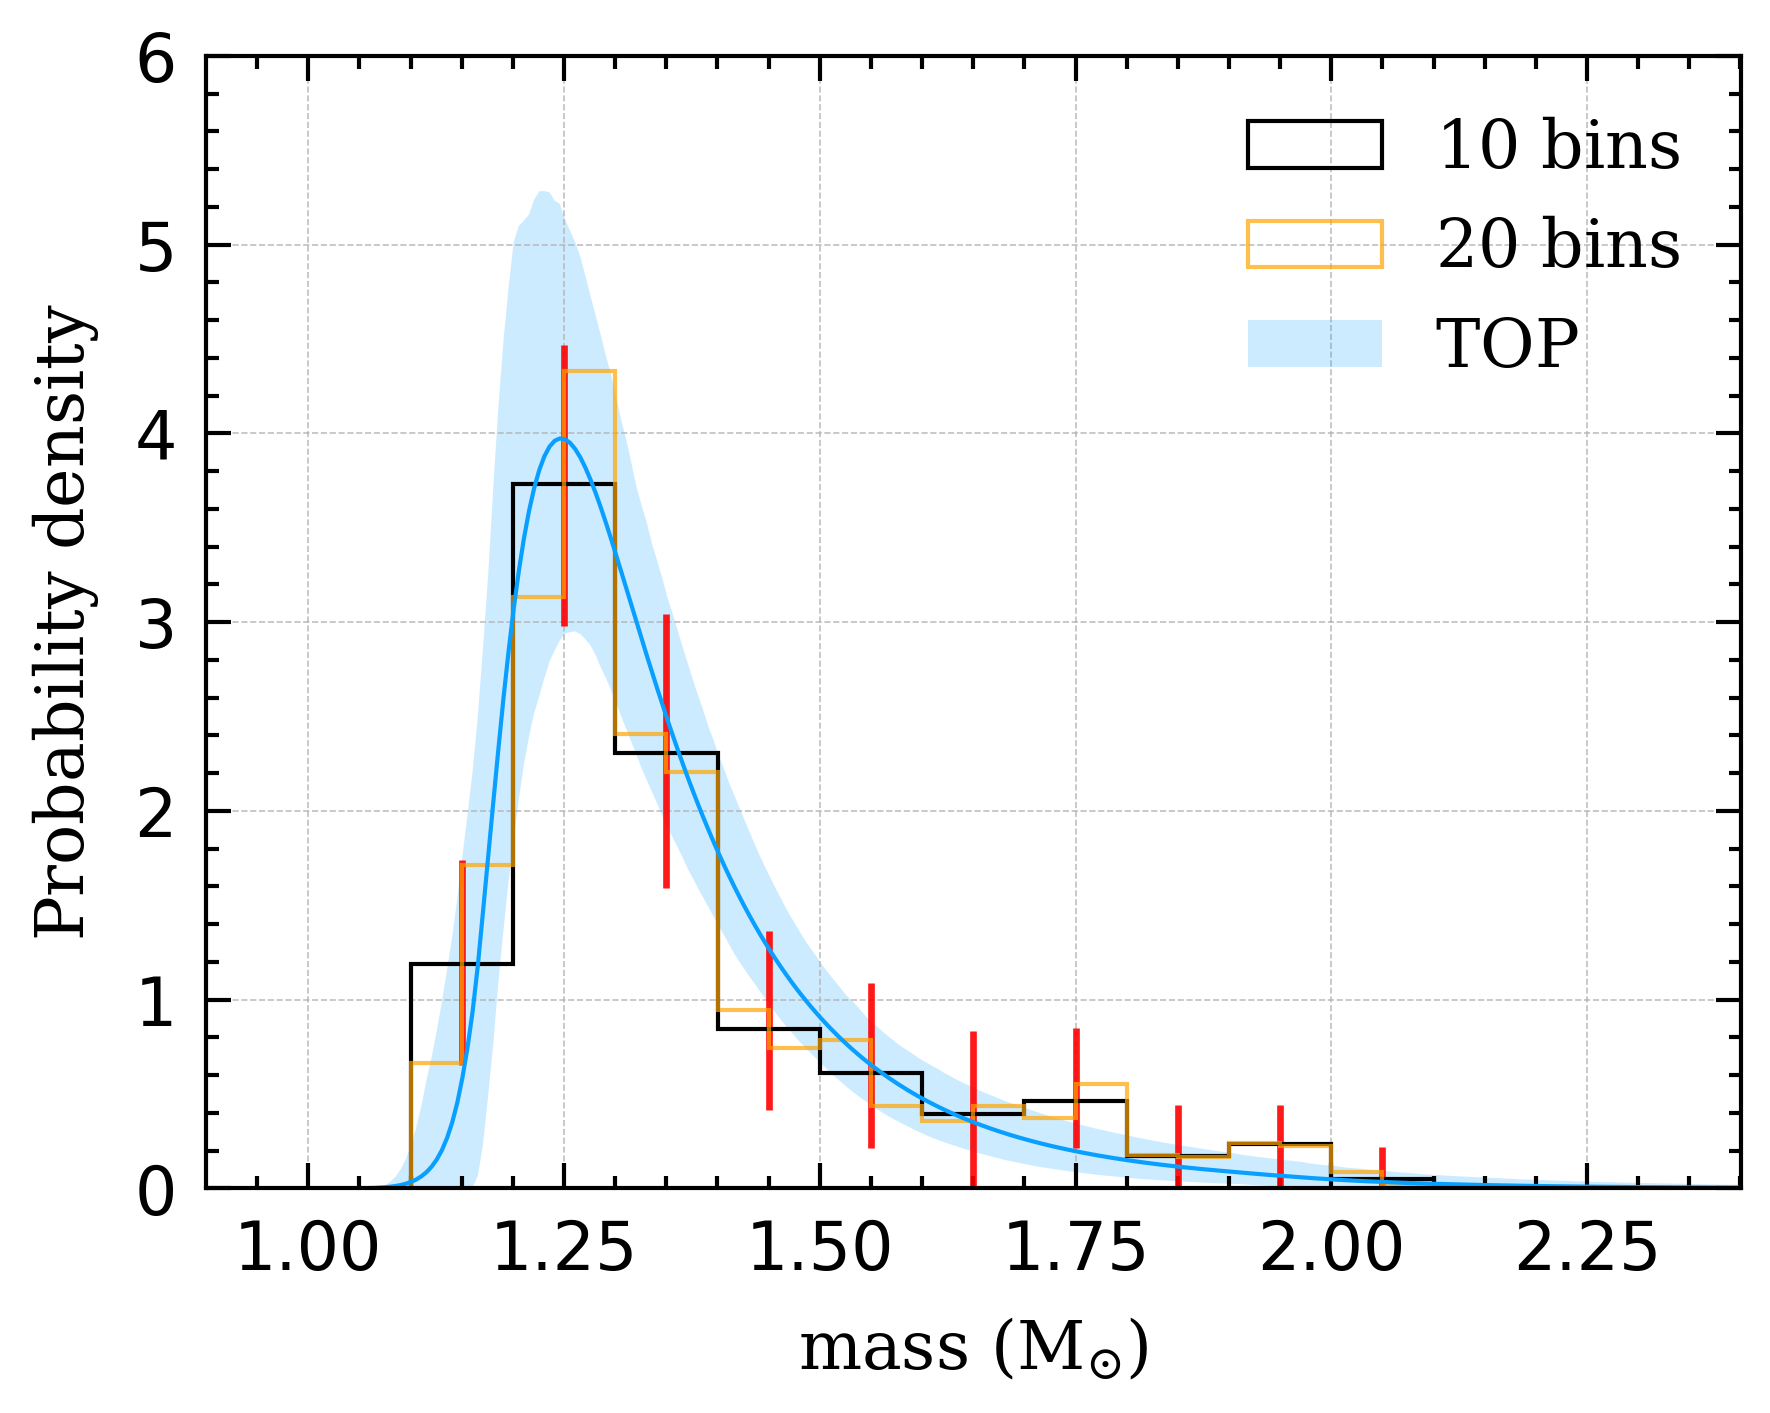

In [10]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.style.use(['science','ieee','no-latex'])
plt.grid(b=True,linestyle='--',lw=0.2,alpha=0.8)


dm=0.1
start_m=1.1
end_m=2.3
nbin=10 #int(( end_m-start_m )/dm)-1


li_hist_data=np.zeros((5000,48))
li_all_hist=np.zeros((5000,nbin))
li_mean=np.zeros(48)

for i in range(48):
    li_hist_data[:,i] = li_data[i*5000:(i+1)*5000]
    li_mean[i]=np.mean(li_data[i*5000:(i+1)*5000])
    
standar_bins_edges=np.zeros(11)

for i in range(10+1): #bins_edges more than one size compared bins
    standar_bins_edges[i]= start_m + i*0.1

more_bins_edges=np.zeros(21)
for j in range(21):
    more_bins_edges[j]=start_m + j*0.05
    
f41_bins_edges=np.zeros(41)
for j in range(41):
    f41_bins_edges[j]=start_m + j*(1.2/40)
    
    

plt.hist(li_data,bins=standar_bins_edges,histtype='step',lw=0.5,density=True,label=r'$\rm{10\,\,bins}$')
plt.hist(li_data,bins=more_bins_edges,histtype='step',ls='-',color='orange',lw=0.5,alpha=0.7,density=True,label=r'$\rm{20\,\,bins}$')
    
plt.errorbar(t10_bins_c, t10_bins_h, yerr=t10_bins_err,fmt='none',color='r',lw=0.8,alpha=0.9) #or none for no line and ponits


####part2 

li_dat=np.zeros(48)
for i in range(48):
    li_dat[i]=np.mean(li_data[i*5000:(i+1)*5000])    
    

plt.plot(x, li_ppd_TOP, ls='-',color='#089FFF',lw=0.5)
plt.fill_between(x, li_err_TOP[0,:], li_err_TOP[1,:],alpha=0.2, facecolor='#089FFF',label=r'$\rm{TOP}$')


plt.xlabel(r'$\rm{mass\,\, (M_{\odot})}$')
plt.ylabel(r'$\rm{Probability\,\,density}$')
plt.xlim(0.9,2.4)
plt.ylim(0,6)
plt.legend(loc='upper right')
#plt.savefig('top_data.jpg')